<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/EEG%20DFA%20investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne==1.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 1.7 MB/s eta 0:00:00


In [3]:
import mne

In [9]:
!pip install pyEDFlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.5 MB/s eta 0:00:00


In [12]:
import pyedflib
from pyedflib import highlevel

In [13]:
path = "https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/EDF_example_FS_healthy.edf"
signals, signal_headers, header = highlevel.read_edf(path)

FileNotFoundError: https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/EDF_example_FS_healthy.edf: can not open file, no such file or directory

In [14]:
edf_path = 'EDF_example_FS_healthy.edf'
# загрузка файла (данные в структуре переданы в переменную)
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)

Extracting EDF parameters from /content/EDF_example_FS_healthy.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28799  =      0.000 ...   224.992 secs...


In [15]:
!pip install hurst

In [16]:
!pip install MFDFA

In [18]:
from scipy import signal
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from MFDFA import MFDFA
import pandas as pd
from scipy.stats import linregress

In [20]:
data_from_raw_edf.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1-G2, EEG Fpz-G2, EEG Fp2-G2, EEG F7-G2, EEG F3-G2, EEG ...
 chs: 28 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 70.0 Hz
 meas_date: 2020-10-15 15:49:54 UTC
 nchan: 28
 projs: []
 sfreq: 128.0 Hz
>

In [23]:
data_from_raw_edf.ch_names

['EEG Fp1-G2',
 'EEG Fpz-G2',
 'EEG Fp2-G2',
 'EEG F7-G2',
 'EEG F3-G2',
 'EEG Fz-G2',
 'EEG F4-G2',
 'EEG F8-G2',
 'EEG T3-G2',
 'EEG C3-G2',
 'EEG Cz-G2',
 'EEG C4-G2',
 'EEG T4-G2',
 'EEG T5-G2',
 'EEG P3-G2',
 'EEG Pz-G2',
 'EEG P4-G2',
 'EEG T6-G2',
 'EEG O1-G2',
 'EEG O2-G2',
 'EEG F9-G2',
 'EEG T9-G2',
 'EEG ECG-G2',
 'EEG P9-G2',
 'EEG F10-G2',
 'EEG T10-G2',
 'EEG P10-G2',
 'Value MKR+-MKR-']

In [24]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
data_from_raw_edf.drop_channels('Value MKR+-MKR-')

<RawEDF | EDF_example_FS_healthy.edf, 27 x 28800 (225.0 s), ~6.0 MB, data loaded>

In [26]:
rename_dict = {
    'EEG Fp1-G2-0': 'Fp1',
    'EEG Fp2-G2-0': 'Fp2',
    #'EEG Fp2-G2-1': 'F3',
    #'EEG F4-G2': 'F4',
    'EEG Fp2-G2-1': 'F7',
    'EEG Fp1-G2-1': 'F8',
    #'EEG Fz-G2': 'Fz',
    'EEG C3-G2': 'C3',
    'EEG C4-G2': 'C4',
    #'EEG Cz-G2': 'Cz',
    #'EEG P3-G2': 'P3',
    #'EEG P4-G2': 'P4',
    #'EEG Pz-G2': 'Pz',
    #'EEG O1-G2': 'O1',
    #'EEG O2-G2': 'O2',
    'EEG T3-G2': 'T3',
    'EEG T4-G2': 'T4',
    #'EEG T5-G2': 'T5',
    #'EEG T6-G2': 'T6',
    #'EEG T9-G2': 'T9',
    #'EEG P9-G2': 'P9',
    #'EEG F10-G2': 'F10',
    #'EEG T10-G2': 'T10',
    #'EEG P10-G2': 'P10'
}
data_from_raw_edf.rename_channels(rename_dict)

ValueError: Invalid channel name(s) {'EEG Fp2-G2-0', 'EEG Fp1-G2-0', 'EEG Fp2-G2-1', 'EEG Fp1-G2-1'} are not present in info

In [27]:
channel_names = data_from_raw_edf.info['ch_names']
hurst_exponents = []

In [28]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [30]:
for channel_index, channel_name in enumerate(channel_names):
    fs = data_from_raw_edf.info['sfreq']
    lowcut = 1
    highcut = 40
    c_signal = eeg_data[channel_index]
    filtered_signal = butter_bandpass_filter(c_signal, lowcut, highcut, fs)
    eeg_data[channel_index] = filtered_signal
    lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))
    q = 2
    order = 1

    try:
        lag, dfa = MFDFA(filtered_signal, lag=lag, q=q, order=order)
        del_nan = np.argwhere(np.isnan(dfa))
        dfa = np.delete(dfa,del_nan[:,0])
        lag = np.delete(lag,del_nan[:,0])
        H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1],np.log10(dfa[0:-1]),1)
        hurst_exponents.append((channel_name, H_hat))
    except Exception as e:
        print(f"Ошибка при обработке канала {channel_name}: {e}")
        hurst_exponents.append((channel_name, np.nan))
hurst_df = pd.DataFrame(hurst_exponents, columns=['Имя канала', 'Показатель индекса Херста'])
print(hurst_df)


    Имя канала  Показатель индекса Херста
0   EEG Fp1-G2                   0.872085
1   EEG Fpz-G2                   0.631794
2   EEG Fp2-G2                   0.757056
3    EEG F7-G2                   0.688901
4    EEG F3-G2                   0.678048
5    EEG Fz-G2                   0.640029
6    EEG F4-G2                   0.695151
7    EEG F8-G2                   0.679648
8    EEG T3-G2                   0.785492
9    EEG C3-G2                   0.654630
10   EEG Cz-G2                   0.627682
11   EEG C4-G2                   0.673498
12   EEG T4-G2                   0.684726
13   EEG T5-G2                   0.689828
14   EEG P3-G2                   0.663250
15   EEG Pz-G2                   0.660840
16   EEG P4-G2                   0.635859
17   EEG T6-G2                   0.689457
18   EEG O1-G2                   0.661934
19   EEG O2-G2                   0.677929
20   EEG F9-G2                   0.705500
21   EEG T9-G2                   0.682150
22  EEG ECG-G2                   0

In [31]:
montage = mne.channels.make_standard_montage('standard_1020')
pos = montage.get_positions()['ch_pos']

/usr/local/lib/python3.10/dist-packages/mne/io/open.py:161: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dirpos = int(tag.data)
/usr/local/lib/python3.10/dist-packages/mne/io/tag.py:299: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  version=int(np.frombuffer(fid.read(4), dtype=">i4")),
/usr/local/lib/python3.10/dist-packages/mne/io/tag.py:301: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  secs=int(np.frombuffer(fid.read(4), dtype=">i4")),
/usr/local/lib/python3.10

In [36]:
all_montage_names = montage.ch_names
channel_names = hurst_df['Имя канала'].tolist()
filtered_names = [name for name in channel_names if name in all_montage_names]
names = filtered_names
names

[]

In [33]:
names_hurst = [f"{row['Имя канала']}\n{round(row['Показатель индекса Херста'], 5)}" for index, row in hurst_df.iterrows()]
print(names_hurst)

['EEG Fp1-G2\n0.87209', 'EEG Fpz-G2\n0.63179', 'EEG Fp2-G2\n0.75706', 'EEG F7-G2\n0.6889', 'EEG F3-G2\n0.67805', 'EEG Fz-G2\n0.64003', 'EEG F4-G2\n0.69515', 'EEG F8-G2\n0.67965', 'EEG T3-G2\n0.78549', 'EEG C3-G2\n0.65463', 'EEG Cz-G2\n0.62768', 'EEG C4-G2\n0.6735', 'EEG T4-G2\n0.68473', 'EEG T5-G2\n0.68983', 'EEG P3-G2\n0.66325', 'EEG Pz-G2\n0.66084', 'EEG P4-G2\n0.63586', 'EEG T6-G2\n0.68946', 'EEG O1-G2\n0.66193', 'EEG O2-G2\n0.67793', 'EEG F9-G2\n0.7055', 'EEG T9-G2\n0.68215', 'EEG ECG-G2\n0.5471', 'EEG P9-G2\n0.68659', 'EEG F10-G2\n0.71803', 'EEG T10-G2\n0.70184', 'EEG P10-G2\n0.67362']


In [34]:
hurst_values = np.array([hurst_df[hurst_df['Имя канала'] == name]['Показатель индекса Херста'].values[0] if name in hurst_df['Имя канала'].values else np.nan for name in names])

In [35]:
pos_array = np.stack([pos[name] for name in names], axis=0)[:, :2]
pos_array

ValueError: need at least one array to stack

NameError: name 'pos_array' is not defined

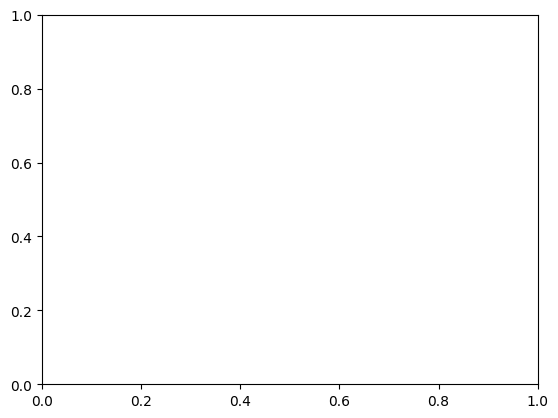

In [37]:
fig, ax = plt.subplots()
im, cn = mne.viz.plot_topomap(hurst_values, pos_array, names=names_hurst, show_names=True, sensors=True, axes=ax)


In [39]:
def compute_energy_in_frequency_band(freqs, psd, band):
    indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    energy = np.trapz(psd[indices], freqs[indices])
    return energy

def plot_spectrogram_and_energy(signal, sample_rate):
    freqs, psd = welch(signal, sample_rate)

    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 100)

    energy_delta = compute_energy_in_frequency_band(freqs, psd, delta_band)
    energy_theta = compute_energy_in_frequency_band(freqs, psd, theta_band)
    energy_alpha = compute_energy_in_frequency_band(freqs, psd, alpha_band)
    energy_beta  = compute_energy_in_frequency_band(freqs, psd, beta_band)
    energy_gamma = compute_energy_in_frequency_band(freqs, psd, gamma_band)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, psd)
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

    plt.subplot(2, 1, 2)
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    energies = [energy_delta, energy_theta, energy_alpha, energy_beta, energy_gamma]
    plt.bar(bands, energies, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.title('Energy in Different Frequency Bands')
    plt.xlabel('Frequency Band')
    plt.xticks(np.arange(5), ('Delta, 0.5..4', 'Theta, 4..8', 'Alpha, 8..13', 'Beta, 13..30', 'Gamma, 30..'))
    plt.ylabel('Energy')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()


sample_rate = data_from_raw_edf.info['sfreq']


for channel_index, channel_name in enumerate(names):
    print(f"Обработка канала: {channel_name}")
    signal = eeg_data[channel_index]
    plot_spectrogram_and_energy(signal, sample_rate)

In [42]:
c_index = channel_names.index(channel_names[0])
c_signal = eeg_data[c_index]
fs = data_from_raw_edf.info['sfreq']
lowcut = 1
highcut = 40

In [46]:
# delta_t = 450
# delta_t = 900
delta_t = 18
window_size = int(delta_t * fs)
windows = [c_signal[i:i + window_size] for i in range(0, len(c_signal), window_size) if len(c_signal[i:i + window_size]) == window_size]
hurst_exponents_windowed = []

In [47]:
for window_index, window in enumerate(windows):
  lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))
  q = 2
  order = 1

  try:
      lag, dfa = MFDFA(window, lag=lag, q=q, order=order)
      del_nan = np.argwhere(np.isnan(dfa))
      dfa = np.delete(dfa, del_nan[:,0])
      lag = np.delete(lag, del_nan[:,0])
      H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1], np.log10(dfa[0:-1]), 1)
      hurst_exponents_windowed.append((window_index + 1, H_hat))
  except Exception as e:
      print(f"Ошибка при обработке окна {window_index + 1}: {e}")
      hurst_exponents_windowed.append((window_index + 1, np.nan))

In [48]:
hurst_df_windowed = pd.DataFrame(hurst_exponents_windowed, columns=['Номер окна', 'Показатель индекса Херста'])
print(hurst_df_windowed)

    Номер окна  Показатель индекса Херста
0            1                   0.695969
1            2                   0.805684
2            3                   0.877112
3            4                   0.830621
4            5                   0.800244
5            6                   0.739141
6            7                   0.809378
7            8                   0.899084
8            9                   0.797025
9           10                   0.823127
10          11                   0.881146
11          12                   0.938588


In [52]:
xticks_values = np.linspace(0,200, 10)
xticks_values

array([  0.        ,  22.22222222,  44.44444444,  66.66666667,
        88.88888889, 111.11111111, 133.33333333, 155.55555556,
       177.77777778, 200.        ])

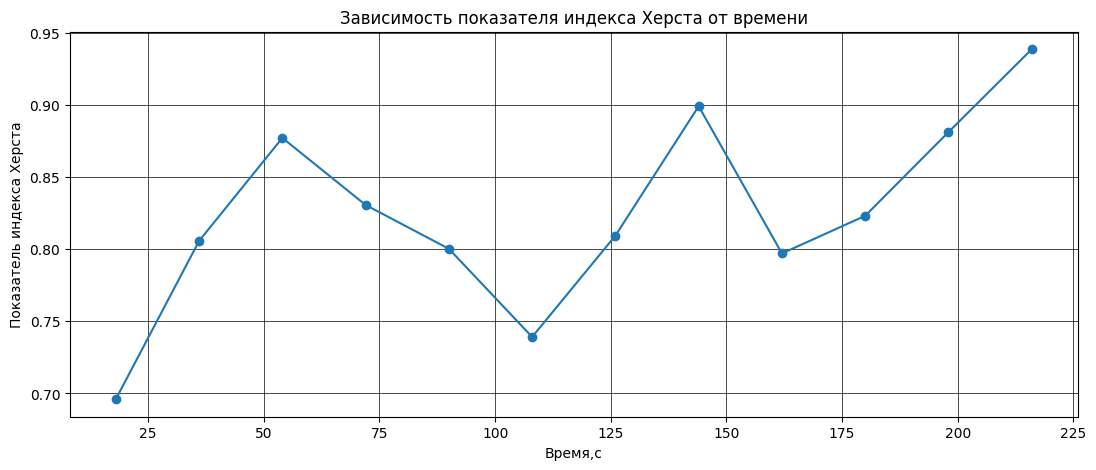

In [56]:
plt.figure(figsize=(13, 5))
times = (np.arange(len(hurst_df_windowed)) + 1) * delta_t
plt.plot(times, hurst_df_windowed['Показатель индекса Херста'], marker='o')

plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.xlabel('Время,с')
plt.ylabel('Показатель индекса Херста')
plt.title('Зависимость показателя индекса Херста от времени')
plt.grid(True)
plt.show()

In [57]:
i = 1
hurst_values = []
window_sizes = []
while True:
    window_size = int(delta_t * i * fs)
    if window_size > len(c_signal):
        break
    window_signal = c_signal[:window_size]
    try:
        lag, dfa = MFDFA(window_signal, lag=lag, q=q, order=order)
        del_nan = np.argwhere(np.isnan(dfa))
        dfa = np.delete(dfa, del_nan[:, 0])
        lag = np.delete(lag, del_nan[:, 0])
        H_hat, _ = np.polyfit(np.log10(lag)[0:-1], np.log10(dfa[0:-1]), 1)
        hurst_values.append(H_hat)
        window_sizes.append(window_size / fs)
    except Exception as e:
        print(f"Ошибка при обработке окна {i}: {e}")
        hurst_values.append(np.nan)
    i += 1
window_numbers = list(range(1, len(hurst_values) + 1))
results_df = pd.DataFrame({
    'Номер окна': window_numbers,
    'Показатель индекса Херста': hurst_values
})

print(results_df)

    Номер окна  Показатель индекса Херста
0            1                   0.695969
1            2                   0.697891
2            3                   0.700833
3            4                   0.707804
4            5                   0.710609
5            6                   0.714490
6            7                   0.714573
7            8                   0.720153
8            9                   0.722122
9           10                   0.725112
10          11                   0.735396
11          12                   0.835916


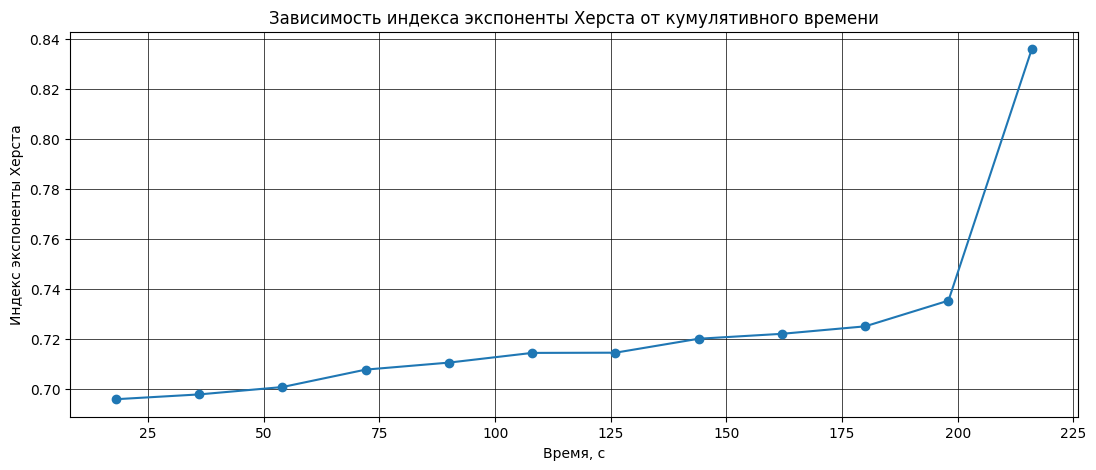

In [59]:
plt.figure(figsize=(13, 5))
plt.plot(window_sizes, hurst_values, marker='o')

plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.xlabel('Время, с')
plt.ylabel('Индекс экспоненты Херста')
plt.title('Зависимость индекса экспоненты Херста от кумулятивного времени')
plt.grid(True)
plt.show()